In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F  #filtering
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# starting a Spark session
spark = (
    SparkSession.builder.appName('Parkres & Domain Analysis')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)

park_domain = spark.read.parquet('../data/curated/parkres/parkres_domain.parquet')
park_domain.limit(5)

your 131072x1 screen size is bogus. expect trouble
24/09/27 08:42:24 WARN Utils: Your hostname, LAPTOP-KOQUIUN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/27 08:42:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/27 08:42:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


address,property_sa2_name,extracted_price,nearest_parkres_distance,nearest_parkres_name,parkres_sa2_name
(Leased) 3 Yarra ...,South Yarra - North,460.0,1067.029,Herring Island,Richmond (South) ...
004B/12 Albert St...,Hawthorn East,400.0,2979.433,Lower Yarra River...,Hawthorn - North
01/390 Burwood Hi...,Burwood (Vic.),320.0,2778.327,Wattle Park,Burwood (Vic.)
04/949 Dandenong ...,Malvern East,365.0,6456.117,Herring Island,Richmond (South) ...
1.04/69 Flemingto...,North Melbourne,670.0,1319.604,Carlton Court Hou...,Carlton


In [4]:
park_domain_pd = park_domain.toPandas()

       nearest_parkres_distance  extracted_price
count               9565.000000      9565.000000
mean                2395.367543       638.404171
std                 1474.137283       235.599952
min                   48.085000         1.000000
25%                 1227.690000       500.000000
50%                 2033.305000       595.000000
75%                 3412.398000       720.000000
max                 8904.808000      1895.000000


Correlation coefficient: -0.07
R-squared: 0.01
P-value: 0.0000
Slope: -0.01
Intercept: 666.95


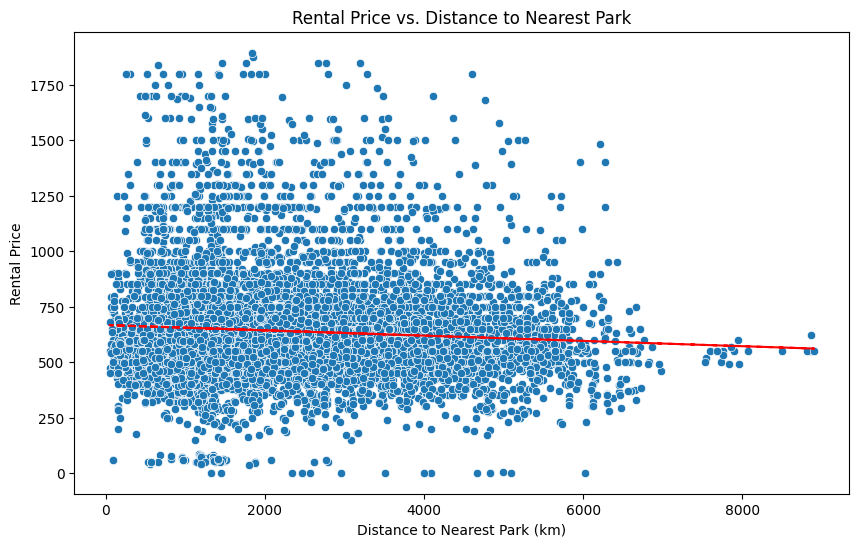

In [5]:
# Display basic statistics
print(park_domain_pd[['nearest_parkres_distance', 'extracted_price']].describe())
print("\n")

# Calculate correlation
correlation = park_domain_pd['extracted_price'].corr(park_domain_pd['nearest_parkres_distance'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='nearest_parkres_distance', y='extracted_price', data=park_domain_pd)
plt.title('Rental Price vs. Distance to Nearest Park')
plt.xlabel('Distance to Nearest Park (km)')
plt.ylabel('Rental Price')

# Add a trend line
z = np.polyfit(park_domain_pd['nearest_parkres_distance'], park_domain_pd['extracted_price'], 1)
p = np.poly1d(z)
plt.plot(park_domain_pd['nearest_parkres_distance'], p(park_domain_pd['nearest_parkres_distance']), "r--")

# Perform a simple linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(park_domain_pd['nearest_parkres_distance'], park_domain_pd['extracted_price'])

print(f"Correlation coefficient: {correlation:.2f}")
print(f"R-squared: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")

plt.show()

In [6]:
# Independent variable (X) - nearest_parkres_distance
X = park_domain_pd['nearest_parkres_distance']

# Add a constant to the independent variable (for intercept)
X = sm.add_constant(X)

# Dependent variable (Y) - extracted_price
Y = park_domain_pd['extracted_price']

# Fit the model
model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        extracted_price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     53.48
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           2.82e-13
Time:                        08:42:35   Log-Likelihood:                -65790.
No. Observations:                9565   AIC:                         1.316e+05
Df Residuals:                    9563   BIC:                         1.316e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Checking for Multicollinearity

In [7]:
# Ensure only numeric columns are used in this step
X = park_domain_pd[['nearest_parkres_distance']]  # Add more features if you have them

# Add constant for the intercept
X = sm.add_constant(X)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature       VIF
0                     const  3.640668
1  nearest_parkres_distance  1.000000


VIF for nearest_parkres_distance is 1.0, which means there’s no correlation with other predictors (since it's the only variable apart from the intercept).